In [174]:
using DataFrames, CSV, Plots
include("/Users/johnbuckner/.julia/dev/UniversalDiffEq.jl/src/UniversalDiffEq.jl")


Main.UniversalDiffEq

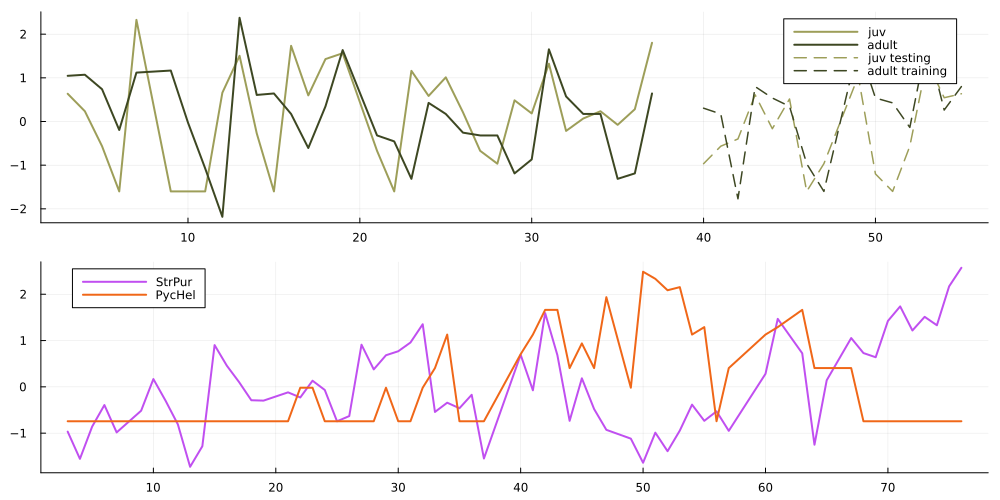

In [175]:
site = 4
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
dat = sort(dat,:PERIOD)

dat_states = dat[dat.SITE .== site,[:PERIOD,:MacJuv,:MacPyr]]
training = dat_states[dat_states.PERIOD .< 40,:]
testing = dat_states[(dat_states.PERIOD .>= 40) .& (dat_states.PERIOD .<= 55),:]
validation = dat_states[dat_states.PERIOD .> 55,:]

X = dat[dat.SITE .== site,[:PERIOD,:MesFra,:StrPur,:PteCal,:PycHel,:SemPul]]



p1 = Plots.plot(training.PERIOD, training.MacJuv, label = "juv", width = 2, color = "#9d9e59" )
Plots.plot!(training.PERIOD, training.MacPyr, label = "adult", width = 2, color = "#3d4722")
Plots.plot!(testing.PERIOD, testing.MacJuv, label = "juv testing", width = 1.5, linestyle = :dash, color = "#9d9e59")
Plots.plot!(testing.PERIOD, testing.MacPyr, label = "adult training", width = 1.5,linestyle = :dash, color = "#3d4722")
p2 = Plots.plot(X.PERIOD, X.StrPur, label = "StrPur", width = 2, color = "#c04ff0" )
Plots.plot!(X.PERIOD, X.PycHel, label = "PycHel", width = 2, color = "#f06718" )
plot(p1,p2, layout = (2,1), size = (1000,500))

In [176]:
X[1:2,:]

Row,PERIOD,MesFra,StrPur,PteCal,PycHel,SemPul
,Int64,Float64,Float64,Float64,Float64,Float64
1,3,0.481251,-0.966806,0.219836,-0.74234,-1.97455
2,4,-0.0570733,-1.55477,-0.0220743,-0.74234,-2.20364


In [ ]:
covars = [2,4,5]

NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(2+length(covars),2, hidden = 10, seed = 5491)

function dudt(u,X,p,t,covars)
    return NN(vcat(u,X[covars]), p.NN) # index 3 is pycnopodia  ,X[1:2]
end

init_parameters = (NN = NNparameters, )

NODE = UniversalDiffEq.CustomDerivatives(training,X,(u,X,p,t) -> dudt(u,X,p,t,covars),
                                            init_parameters;time_column_name = "PERIOD")

UniversalDiffEq.train!(NODE, loss_function = "spline gradient matching", 
        regularization_weight = 1e-5, optim_options = (maxiter = 500, step_size = 0.025), 
        loss_options = (σ = 0.05, τ = 0.1, T = 4*size(training)[1]))
nothing

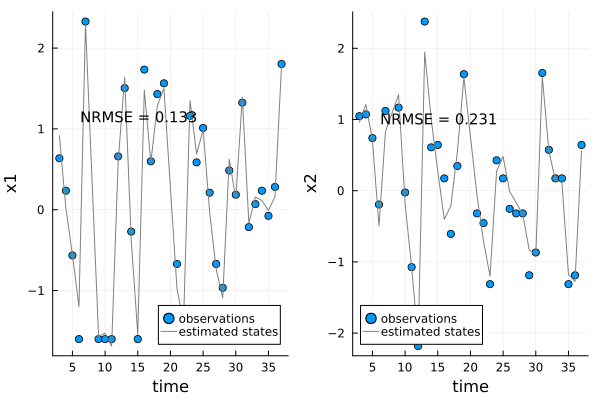

In [178]:
UniversalDiffEq.plot_state_estimates(NODE)

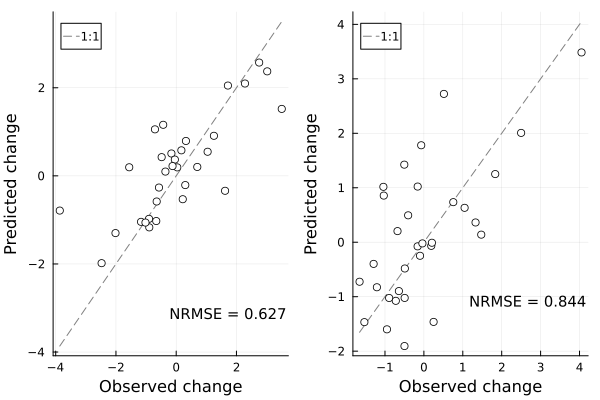

In [179]:
UniversalDiffEq.plot_predictions(NODE)

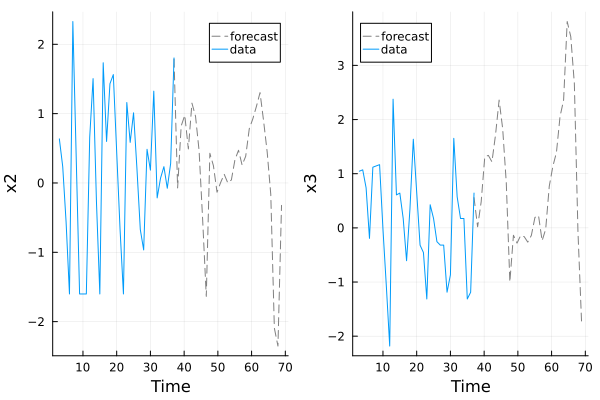

In [180]:
plt,(p1,p2)=UniversalDiffEq.plot_forecast(NODE, 30)
plt

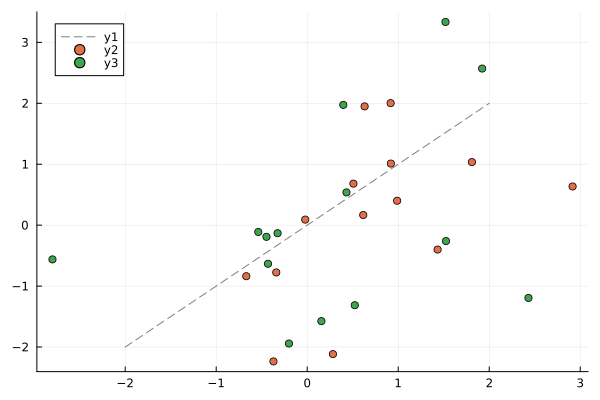

In [182]:
inits,obs,preds = UniversalDiffEq.predictions(NODE,testing)


delta_obs = obs .- inits
delta_pred = preds .- inits

Plots.plot([-2,2],[-2,2], color = "grey", linestyle = :dash)
Plots.scatter!(delta_pred[1,:], delta_obs[1,:])
Plots.scatter!(delta_pred[2,:], delta_obs[2,:])


In [183]:
cor(delta_obs[1,:], delta_pred[1,:])

0.498078138918859

In [184]:
cor(delta_obs[2,:], delta_pred[2,:])

0.33850832539835857